In [3]:
import tt
from __future__ import division
from math import cos, pi
import numpy as np
import matplotlib.pyplot as plt
import os, sys 
sys.path.insert(0,os.path.pardir)
from Bayes_util.lib.interpolation_util import evaluate_lagrange, get_legendre_basis, lagrange_to_legendre, get_cheb_points, evaluate_function_representation 
                                             
%matplotlib inline

In [2]:
def evaluate(tensor, _nodes, _poly='Legendre', _samples=None):
    """
    working interpolation and sampling method. Just insert the tensor corresponding to the evaluation at
    quadrature points and the polynomial system you want to use.
    :param tensor: tt tensor sampled at quadrature points
    :param _nodes: quadrature nodes in one dimension
    :param _poly: either Lagrange or Legendre
    :param _samples: points to sample in each dimension at. corresponds to tensor indices
    :return: value
    """
    raise DeprecationWarning("This function is outdated. Use Bayes_util.lib.bayes_lib.evaluate")
    if _poly == 'Legendre':
        #                                           # Get Legendre polynomials from RV
        poly, norms = get_legendre_basis(max(tensor.n))
        _transfer_matrix, _transfer_basis, _transfer_norms = lagrange_to_legendre(_nodes)
    else:
        if _poly == 'Lagrange':
            poly = [evaluate_lagrange(_samples, _nodes, j) for j in range(len(_nodes))]
        else:
            print "SampleInStochSpace Error: poly='{0}' is unknown".format(_poly)
            raise AttributeError
    #                                               # create array from tensor
    components = tt.tensor.to_list(tt.vector.copy(tensor))
#                                                   loop through components
    for lia in range(len(components)):
        _comp_index = lia
        _comp_value = components[lia]
        # print "shape of new component {0} is [{1},{2},{3}]".format(_comp_index, _comp_value.shape[0],
        #                                                           len(_nodes), _comp_value.shape[2])
        if _comp_index == 0:				        # skip first Core, since it is the space representation
            buffer_tt = _comp_value
            continue
        if _poly == 'Legendre':
            for lia in range(0, _comp_value.shape[0]):
                for lic in range(0, _comp_value.shape[2]):
                    _comp_value[lia, :, lic] = np.dot(_transfer_matrix, _comp_value[lia, :, lic])

        buffer_core = None
        for _lic in range(0, tensor.n[_comp_index]):
            if _poly == 'Legendre':
                if _lic == 0:
                    buffer_core = _comp_value[:, _lic, :] * _transfer_basis[_lic](_samples[_comp_index])/_transfer_norms[_lic]
                else:
                    buffer_core += _comp_value[:, _lic, :] * _transfer_basis[_lic](_samples[_comp_index])/_transfer_norms[_lic]
                continue
            else:
                if _poly == 'Lagrange':
                    _poly_value = poly[_lic][_comp_index]
            try:
                if _lic == 0:
                    buffer_core = _comp_value[:, _lic, :]*_poly_value
                else:
                    buffer_core += _comp_value[:, _lic, :]*_poly_value
            except ValueError:
                print "invalid value at compValue: {0} or poly_value {1}".format(_comp_value[:, _lic, :],
                                                                                 _poly_value)
                quit()
        buffer_tt = np.dot(buffer_tt, buffer_core)

    return buffer_tt[0,0,0]

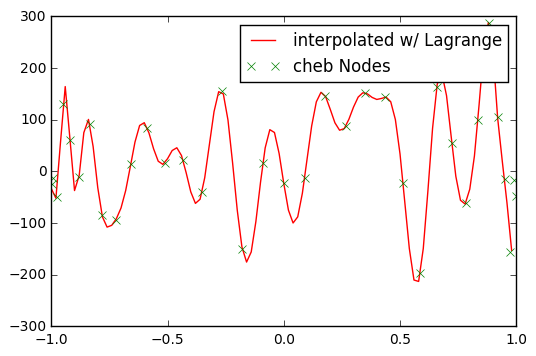

In [2]:
from Bayes_util.lib.bayes_lib import evaluate
cheb_dim = [35]
cheb_points = get_cheb_points(cheb_dim)[0]
#dimensions = [1, cheb_dim[0], cheb_dim[0]]
#ranks = [1, 10, 45, 1]
dimensions = [1,cheb_dim[0],cheb_dim[0],cheb_dim[0],cheb_dim[0],cheb_dim[0]]
ranks = [1,4,7,25,9,8,1]

ten = tt.rand(dimensions,len(dimensions),ranks) 
#ten = ten * tt.vector.norm(ten)**(-1)
x = np.arange(-1,1, 1/50)
#tenLeg = interpolate_in_stoch_space(ten, cheb_points)
#tenLeg = sample(tenLeg, cheb_points, _poly='Legendre', _samples=x)
#tenLag = sample(ten, cheb_points, _poly='Lagrange', _samples=x)
#values_tenLeg = [evaluate(ten, _poly="Legendre", 
#                          _samples=[0,cheb_points[10],x[lia],cheb_points[12],cheb_points[2],cheb_points[3]]) 
#                                    for lia in range(0, len(x))]

values_tenLag = [evaluate(ten, _poly="Lagrange", 
                          _samples=[0,cheb_points[10],x[lia],cheb_points[12],cheb_points[2],cheb_points[3]]) 
                                    for lia in range(0, len(x))]
values_ten = [ten[0,10,lia,12,2,3] for lia in range(ten.n[2])]

plt.plot(x, values_tenLag, '-r', label='interpolated w/ Lagrange')
#plt.plot(x, values_tenLeg, '-b', label='interpolated w/ Legendre')
plt.plot(cheb_points, values_ten, 'xg', label='cheb Nodes')
plt.legend()
plt.show()
#plt.figure()
#plt.semilogy(np.abs(np.array(values_tenLag) - np.array(values_tenLeg)))
#plt.title("Interpolation difference error")
#plt.show()